# 7 - Ising Model: Uniform Sampling

##### Imports:

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.integrate as integrate

##### Functions:

In [2]:
def random_spins(N):
    '''Generate a N x N random lattice of spins, represented as a vector of length N^2.'''
    spins = [-1, 1]
    
    lattice = []
    for i in range(N**2):
        lattice.append(random.choice(spins))
    
    return lattice

In [1]:
def compute_energy(lattice):
    '''Given a lattice, computes the energy according to Hamiltonian for the Ising model.'''
    E = 0
    N = int(np.sqrt(len(lattice))) # obtain N, given the lattice
    
    for i in range(len(lattice)):
        s = lattice[i]
        E += -s*lattice[(i + N + N**2)%N**2]
        E += -s*lattice[(i -  N + N**2)%N**2]
        
        E += -s*lattice[(i + 1 + N**2)%N**2]
        E += -s*lattice[(i -  1 + N**2)%N**2]
    return E/2

In [32]:
def ising_uniform_sampling(N):
    lattice = random_spins(N)
    e = compute_energy(lattice)/(2*N**2)    
    return e

We check a function:

In [4]:
# Check that the 'compute_energy' function gives the correct result for the ground state.
ground_state = [1, 1, 1, 1, 1, 1, 1, 1, 1] # ground state for N = 3
compute_energy(ground_state)

-18.0

## 7.1 - Histogram of energies per bond

In [39]:
N = 4; nreps = 10**4

The following cell takes a bit of time to run.

In [40]:
e_list = []

for i in range(nreps):
    e_list.append(ising_uniform_sampling(N))

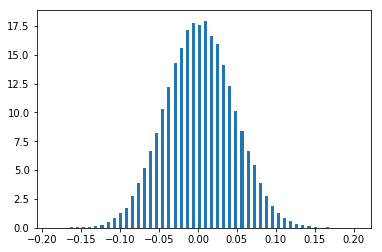

In [41]:
plt.hist(e_list, density = True, bins = 100)
plt.show()

## 7.2 - Hit and miss method

In [58]:
T1 = 10**5; T2 = 10**3; T3 = 10**2; T4 = 10; 

In [59]:
def hit_and_miss(N, T):
    beta = 1/T # work in k_b = 1
    E0 = -2*N**2
    
    lattice = random_spins(N)
    E = compute_energy(lattice)
    
    r = random.uniform(0, 1)
    if r <= np.exp(-beta*(E - E0)):
        return E # hit
    else:
        return 'miss'

In [60]:
def hit_and_miss_algorithm(N, T, nreps):
    e_list = []
    
    for i in range(nreps):
        e = hit_and_miss(N, T)
    
        if e != 'miss':
            e_list.append(e)
    
    return (e_list, len(e_list)/nreps)

In [66]:
N = 4; nreps = 10**4

In [67]:
fracs = []
for T in [T1, T2, T3, T4]:
    fracs.append(hit_and_miss_algorithm(N, T, nreps)[1])

In [68]:
fracs

[0.9994, 0.9709, 0.7226, 0.0475]